<a href="https://colab.research.google.com/github/JSJeong-me/Uniinfo-Machine-Vision/blob/main/U0805/kaggle_cv_lec03_maximum_pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 소개  
Lesson 2에서 합성곱 레이어의 베이스가 특성 추출을 한다는 것을 알아내었다. 특성 추출은 Conv2D 레이어에서 relu 활성화를 통해 이루어진다.    

이번 포스트에서는 이미지를 분류하는 세 번째(그리고 마지막) 단계를 살펴볼 것이다. 케라스의 MaxPool2D 레이어에 해당하는 압축(condense), 그리고 최대 풀링(maximum pooling) 말이다.

# 최대 풀링으로 이루는 압축  
이전에 만든 모델에 압축 단계를 추가하면, 아래와 같다.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = 3), # 활성화는 이루어지지 않음
    layers.MaxPool2D(pool_size = 2)
    # 더 많은 레이어가 추가될 것이다.
])

MaxPool2D 레이어는 Conv2D 레이어와 대부분 비슷하다. 그러나 커널 대신에 간단한 최댓값 함수(maximum function)를 사용하며 kernel_size에 대응하는 파라미터는 pool_size이다. MaxPool2D 레이어는 합성곱 레이어가 커널에 대해 가지는 (훈련 가능한) 가중치만큼 많은 양의 가중치를 가지지 않는다.  
  
  저번 예시를 가져와 추출한 특성을 살펴보자. MaxPool2D 레이어가 응축 단계라는 것을 기억하자.  
  <figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.imgur.com/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
</figure>  
ReLU 함수(감지)를 적용한 후 특성 맵은 0으로 이루어져 검게만 보이는 '빈 공간(dead space)'이 많아지는 것을 확인할 수 있다. 이 '0'값들을 전체 신경망에서 계속 사용하는 것은 불필요하게 신경망의 크기만 키우는 일이 될 것이다. 따라서 우리는 특성 맵을 가장 중요한 부분 - 특성 그 자체 - 만 가지도록 압축한다.  
  
  이것이 최대 풀링이 하는 일이다. 최대 풀링은 원래의 특성 맵에서 일부 활성화를 최대 활성화로 대체시킨다.   
  <figure>
<!-- <img src="./images/3-max-pooling.png" width="600" alt="Maximum pooling replaces a patch with the maximum value in that patch."> -->
<img src="https://imgur.com/hK5U2cd.png" width="400" alt="Maximum pooling replaces a patch with the maximum value in that patch.">
</figure>  
ReLU 활성화 다음에 적용되면, 최대 풀링은 특성을 '극대화'한다. 즉 풀링 단계는 0값들의 픽셀에 비해 효력이 있는 값을 가지는 픽셀의 비율을 높인다.

# 예시 - 최대 풀링 적용하기  
이전 포스트에서의 특성 추출 예시에 '압축' 과정을 추가해보자. 

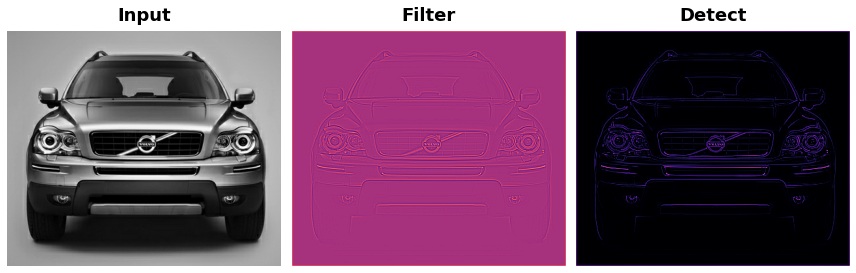

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings('ignore')  # 경고 메시지를 무시하고 숨겨서 출력 셀을 정리함

# 이미지를 읽어들임
image_path = './car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

# 커널 정의하기 
kernel = tf.constant([
    [-1,-1,-1],
    [-1, 8,-1],
    [-1,-1,-1]
], dtype=tf.float32)

# 배치 계산을 위해 출력 형태 변형
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])

# 필터링 단계
image_filter = tf.nn.conv2d(
    input = image,
    filters = kernel,
    strides = 1,
    padding = 'SAME'
)

# 감지 단계
image_detect = tf.nn.relu(image_filter)

# 여태껏 한 작업들 시각화
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

풀링을 적용하기 위해서 tf.nn의 함수 중 하나인 tf.nn.pool을 사용한다. 이는 모델을 만들 때 사용한 MaxPool2D 레이어와 동일한 파이썬 함수이지만 훨씬 간단하고 사용하기 편리하다.

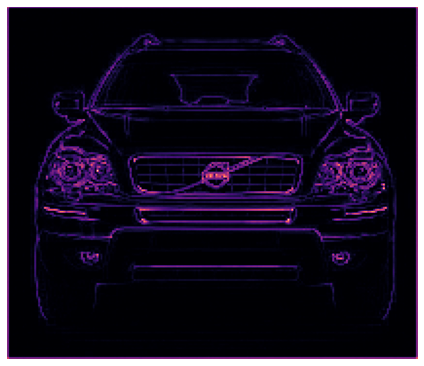

In [3]:
import tensorflow as tf

image_condense = tf.nn.pool(
    input = image_detect, # 감지 작업을 거친 이미지를 입력함
    window_shape = (2,2),
    pooling_type = 'MAX',
    strides = (2,2),
    padding = 'SAME'
)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

# 이동 불변성(Translation Invariance)  
우리는 0값을 가지는 픽셀을 '중요하지 않다'고 정의하였다. 이는 과연 0값 픽셀들이 아무런 정보를 가지고 있지 않다는 뜻일까? 사실 0값 픽셀들은 '위치 정보(positional information)'를 가진다. 빈 공간이지만 여전히 이미지 상 특성의 위치를 특정하는 것이다. MaxPool2D가 이런 픽셀의 일부를 제거하면, 특성 맵에서 이들이 가지고 있던 위치 정보를 제거하는 것이다. 덕분에 합성곱 신경망은 '이동 불변성'을 가진다.   
  
  이는 최대 풀링이 적용된 합성곱 신경망은 특성을 이미지 상 위치 정보를 기반으로 구별하지 않는다는 뜻이다. '이동'을 수학적으로 풀어내면 본래의 모양이나 크기를 잃거나 회전하지 않고 위치를 바꾸는 것을 의미한다.  
    
  아래에 보이는 특성 맵에 최대 풀링이 반복적으로 적용되면 어떤 일이 생기는지 확인해보자.
<figure>
<!-- <img src="./images/4-two-dots.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/97j8WA1.png" width="800" alt="Pooling tends to destroy positional information.">
</figure>
원래 이미지 상 두 개의 점은 반복된 풀링을 거치면서 구별이 불가능해진다. 즉, 풀링이 이 점들의 위치 정보를 제거한 것이다. 신경망이 특성 맵에서 이를 더 이상 구별할 수 없으니, 원래의 이미지에서도 구별하지 못하는 것이다. 따라서 위치 상 차이에 대하여 '불변성'을 띄게 되는 것이다.  
  
  

사실 위 예시처럼 짧은 거리에 대해서만 풀링에 의한 이동 불변성이 생긴다. 서로 멀리 떨어진 특성들은 풀링이 적용되어도 멀리 떨어져 있기에 위치 정보의 일부는 없어질지언정 아예 제거되지는 않는 것이다.  
<figure>
<!-- <img src="./images/4-two-dots-2.png" width="800" alt="Pooling tends to destroy positional information."> -->
<img src="https://i.imgur.com/kUMWdcP.png" width="800" alt="But only over small distances. Two dots far apart stay separated">
</figure>  
특성의 작은 이동에 대한 불변성은 이미지 분류자가 가질 수 있는 좋은 특징(property) 중 하나이다. 시점이나 프레임의 차이로 인해 같은 종류의 특성이 원래 이미지의 여러 위치에 놓여질 경우가 있는데, 우리는 분류자가 이런 경우를 인식하기를 바란다. 불변성이 신경망에 학습된 상태이면 훈련 과정에서 훨씬 적은 양의 데이터로 이런 경우에 같은 특성임을 인식하도록 할 수 있는 것이다. 이 때문에 합성곱 신경망이 압축 레이어만 존재하는 신경망에 비해 훨씬 효율적인 것이다.

# 결론  
이번 포스트에서는 특성 추출의 마지막 단계인, MaxPool2D를 사용한 압축에 대해 공부하였다. 다음 Lesson 4에서는 합성곱과 풀링에 관한 내용을 '슬라이드 창'에 관한 내용으로 마무리할 것이다.